<a href="https://colab.research.google.com/github/Subhashree2016/Relationship-LLM/blob/main/LLM_Embeddings_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Set up DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# 2. Generate Synthetic Data (anomalies included)
def generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1):
    np.random.seed(42)
    normal_data = np.random.normal(loc=50, scale=10, size=(int(num_samples * (1 - anomaly_ratio)), 4))
    normal_labels = np.zeros(len(normal_data))  # Label 0 for normal
    anomalies = np.random.uniform(low=10, high=90, size=(int(num_samples * anomaly_ratio), 4))
    anomaly_labels = np.ones(len(anomalies))  # Label 1 for anomalies

    data = np.vstack([normal_data, anomalies])
    labels = np.hstack([normal_labels, anomaly_labels])

    df = pd.DataFrame(data, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])
    df['label'] = labels
    return df

# Generate data
synthetic_data = generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1)
train_data, test_data = train_test_split(synthetic_data, test_size=0.2, random_state=42)

# Convert features to text format for DistilBERT
train_data['text'] = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)
test_data['text'] = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)

# 3. Function to Get Embeddings from DistilBERT
def get_embeddings(text_data):
    inputs = tokenizer(text_data.tolist(), return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Average over sequence dimension
    return embeddings

# Get embeddings for train and test datasets
train_embeddings = get_embeddings(train_data['text'])
test_embeddings = get_embeddings(test_data['text'])

# 4. Define Classification Head (Anomaly Detector)
class AnomalyDetector(nn.Module):
    def __init__(self, input_dim):
        super(AnomalyDetector, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Instantiate and prepare the anomaly detector model
input_dim = train_embeddings.shape[1]
anomaly_model = AnomalyDetector(input_dim)

# Convert labels to tensors and DataLoader preparation
train_labels = torch.tensor(train_data['label'].values).float().unsqueeze(1)
test_labels = torch.tensor(test_data['label'].values).float().unsqueeze(1)

train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 5. Train the Anomaly Detector Model
criterion = nn.BCELoss()
optimizer = optim.Adam(anomaly_model.parameters(), lr=0.001)
num_epochs = 5

# Training loop
anomaly_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_embeddings, batch_labels in train_loader:
        optimizer.zero_grad()
        predictions = anomaly_model(batch_embeddings)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')

# 6. Evaluate on Test Data
anomaly_model.eval()
with torch.no_grad():
    test_predictions = anomaly_model(test_embeddings).squeeze().numpy()
    test_predictions = (test_predictions > 0.5).astype(int)

# 7. Print Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(test_data['label'], test_predictions))
print("\nClassification Report:")
print(classification_report(test_data['label'], test_predictions))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/5, Loss: 0.3398
Epoch 2/5, Loss: 0.3144
Epoch 3/5, Loss: 0.3083
Epoch 4/5, Loss: 0.2940
Epoch 5/5, Loss: 0.2811
Confusion Matrix:
[[179   0]
 [ 21   0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94       179
         1.0       0.00      0.00      0.00        21

    accuracy                           0.90       200
   macro avg       0.45      0.50      0.47       200
weighted avg       0.80      0.90      0.85       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Confusion Matrix:
[[171   8]
 [ 19   2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       179
           1       0.20      0.10      0.13        21

    accuracy                           0.86       200
   macro avg       0.55      0.53      0.53       200
weighted avg       0.83      0.86      0.84       200

ROC-AUC Score: 0.38


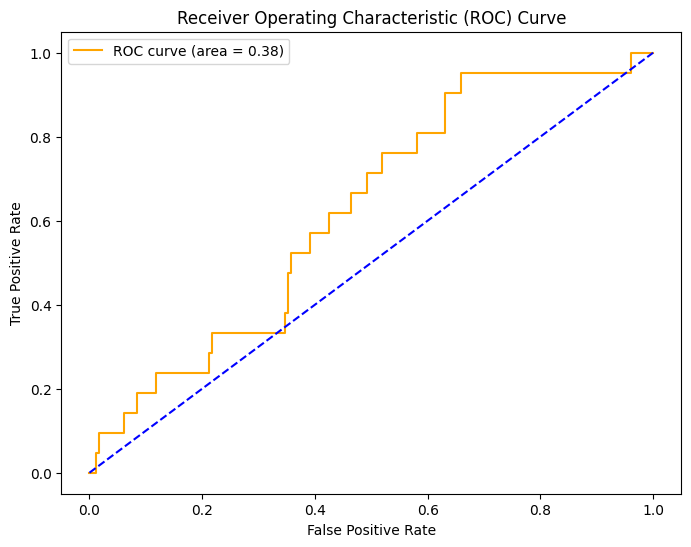

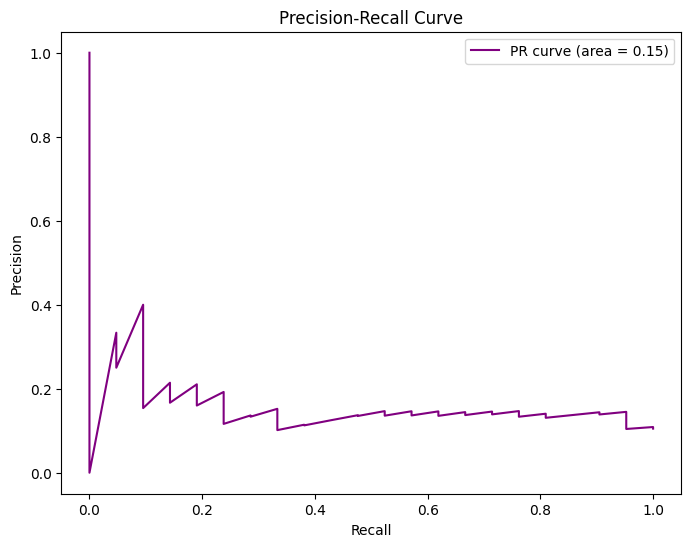

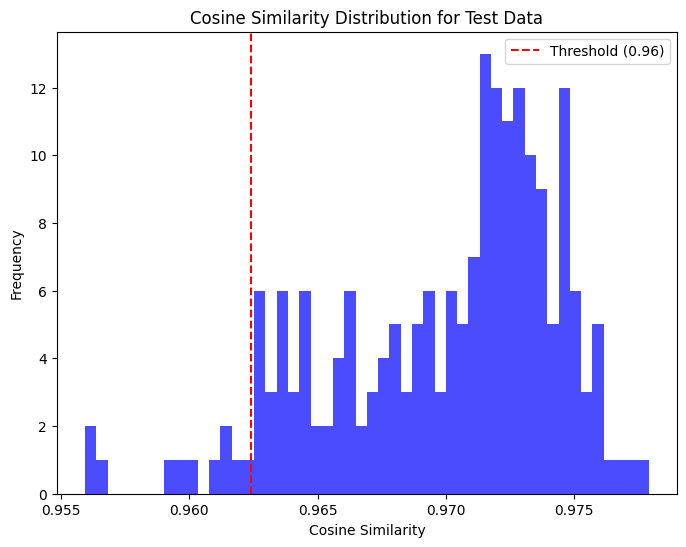

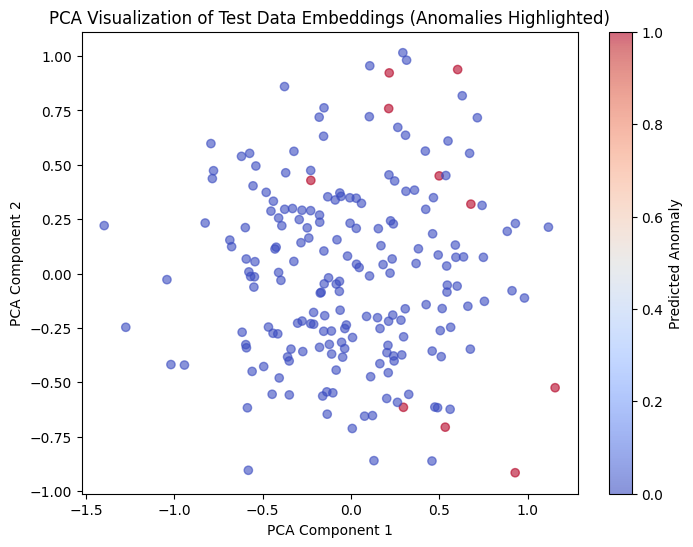

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# 1. Generate Synthetic Data
def generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1):
    np.random.seed(42)
    normal_data = np.random.normal(loc=50, scale=10, size=(int(num_samples * (1 - anomaly_ratio)), 4))
    normal_labels = np.array([0] * len(normal_data))
    anomalies = np.random.uniform(low=10, high=90, size=(int(num_samples * anomaly_ratio), 4))
    anomaly_labels = np.array([1] * len(anomalies))
    data = np.vstack([normal_data, anomalies])
    labels = np.hstack([normal_labels, anomaly_labels])
    columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
    df = pd.DataFrame(data, columns=columns)
    df['label'] = labels
    return df

synthetic_data = generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1)
train_data, test_data = train_test_split(synthetic_data, test_size=0.2, random_state=42)

# 2. Use DistilBERT to Generate Embeddings (with batching to save memory)
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

train_data['text'] = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)
test_data['text'] = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)

def get_embeddings_in_batches(text_data, batch_size=32):
    all_embeddings = []
    for i in range(0, len(text_data), batch_size):
        batch_texts = text_data[i:i+batch_size].tolist()
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True).to(model.device)
        with torch.no_grad():  # disable gradient calculation to save memory
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.append(batch_embeddings)
        torch.cuda.empty_cache()  # clear cache after each batch
    return np.vstack(all_embeddings)

# Get embeddings for train and test datasets
train_embeddings = get_embeddings_in_batches(train_data['text'])
test_embeddings = get_embeddings_in_batches(test_data['text'])

# 3. Cosine Similarity for Anomaly Detection
similarity_matrix = cosine_similarity(test_embeddings)
average_similarity = similarity_matrix.mean(axis=1)
threshold = np.percentile(average_similarity, 5)
test_data['predicted_anomaly'] = (average_similarity < threshold).astype(int)

# 4. Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(test_data['label'], test_data['predicted_anomaly']))
print("\nClassification Report:")
print(classification_report(test_data['label'], test_data['predicted_anomaly']))

# ROC-AUC Score
roc_auc = roc_auc_score(test_data['label'], average_similarity)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_data['label'], -average_similarity)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_data['label'], -average_similarity)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 5. Cosine Similarity Distribution Plot
plt.figure(figsize=(8, 6))
plt.hist(average_similarity, bins=50, color='blue', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.title('Cosine Similarity Distribution for Test Data')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 6. PCA for Visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(test_embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_data['predicted_anomaly'], cmap='coolwarm', alpha=0.6)
plt.title("PCA Visualization of Test Data Embeddings (Anomalies Highlighted)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Predicted Anomaly')
plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2876
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2068
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1284
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0837
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0678
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0605
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0589
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0569
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0556
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0554
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0540
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0543
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0538
Epoch 14/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0520
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0514
Epoch 16/20
91/91 ━

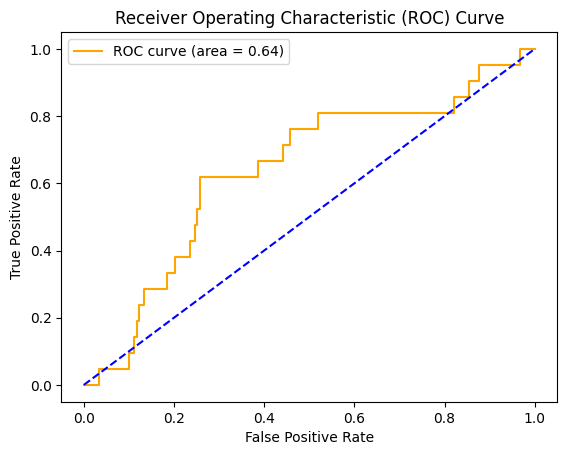

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
import torch

# 1. Generate Synthetic Data
def generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1):
    np.random.seed(42)
    normal_data = np.random.normal(loc=50, scale=10, size=(int(num_samples * (1 - anomaly_ratio)), 4))
    normal_labels = np.array([0] * len(normal_data))
    anomalies = np.random.uniform(low=10, high=90, size=(int(num_samples * anomaly_ratio), 4))
    anomaly_labels = np.array([1] * len(anomalies))
    data = np.vstack([normal_data, anomalies])
    labels = np.hstack([normal_labels, anomaly_labels])
    columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
    df = pd.DataFrame(data, columns=columns)
    df['label'] = labels
    return df

# 2. Generate and Split the Data
synthetic_data = generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1)
train_data, test_data = train_test_split(synthetic_data, test_size=0.2, random_state=42)

# 3. Use DistilBERT to Generate Embeddings in Batches
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

def get_embeddings(text_data, batch_size=64):
    embeddings = []
    for i in range(0, len(text_data), batch_size):
        batch = text_data[i:i + batch_size].tolist()
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

train_data['text'] = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)
test_data['text'] = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)

# Get embeddings in batches
train_embeddings = get_embeddings(train_data['text'])
test_embeddings = get_embeddings(test_data['text'])

# 4. Apply PCA to Reduce Embedding Dimensionality
pca = PCA(n_components=32)  # Adjust to control dimensionality and memory usage
train_embeddings = pca.fit_transform(train_embeddings)
test_embeddings = pca.transform(test_embeddings)

# 5. Balance Training Dataset with Oversampling
ros = RandomOverSampler(random_state=42)
balanced_train_embeddings, balanced_train_labels = ros.fit_resample(train_embeddings, train_data['label'])

# 6. Build and Train a Smaller Autoencoder Model
input_dim = balanced_train_embeddings.shape[1]
encoding_dim = 16

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Train on normal data only (label == 0)
normal_train_embeddings = balanced_train_embeddings[balanced_train_labels == 0]
autoencoder.fit(normal_train_embeddings, normal_train_embeddings, epochs=20, batch_size=8, shuffle=True, verbose=1)

# 7. Calculate Reconstruction Error Threshold
reconstructed_train_data = autoencoder.predict(normal_train_embeddings, batch_size=8)
train_reconstruction_error = np.mean(np.square(normal_train_embeddings - reconstructed_train_data), axis=1)
threshold = np.percentile(train_reconstruction_error, 95)

# 8. Apply Autoencoder on Test Data and Detect Anomalies
reconstructed_test_data = autoencoder.predict(test_embeddings, batch_size=8)
reconstruction_error = np.mean(np.square(test_embeddings - reconstructed_test_data), axis=1)
test_data['predicted_anomaly'] = (reconstruction_error > threshold).astype(int)

# 9. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(test_data['label'], test_data['predicted_anomaly']))
print("\nClassification Report:")
print(classification_report(test_data['label'], test_data['predicted_anomaly']))

# ROC-AUC
roc_auc = roc_auc_score(test_data['label'], reconstruction_error)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(test_data['label'], reconstruction_error)
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="blue", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


Precision: 0.1000
Recall: 0.0476
F1-score: 0.0645
AUC-ROC: 0.4262


<ipython-input-12-f1742796b28f>:111: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=corrected_data['feature_1'], y=corrected_data['feature_2'], palette='coolwarm')


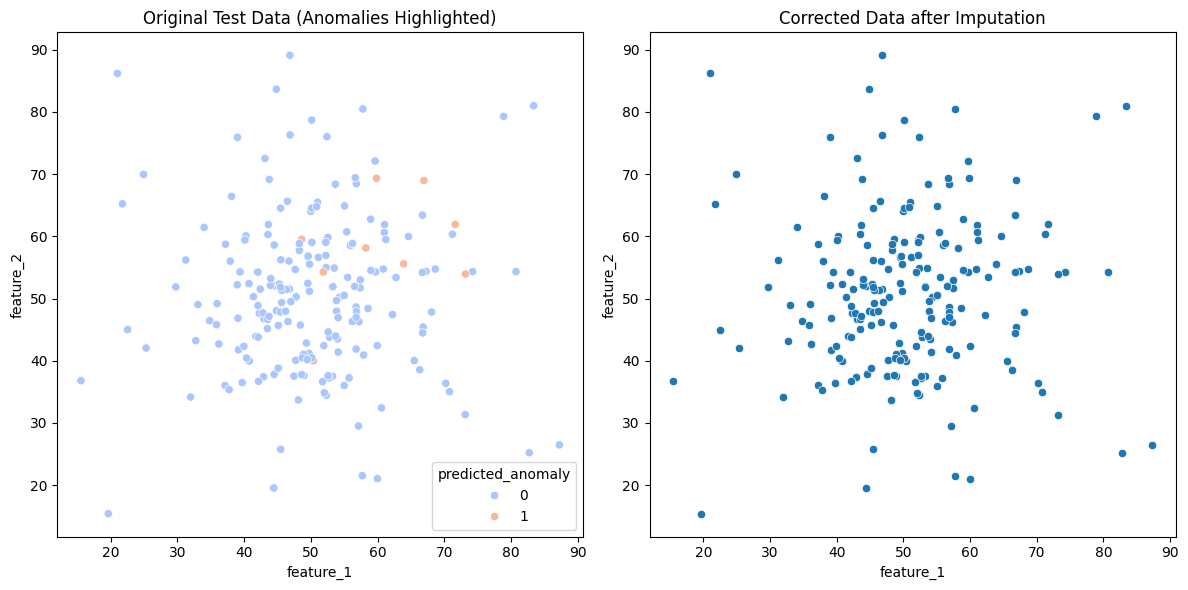

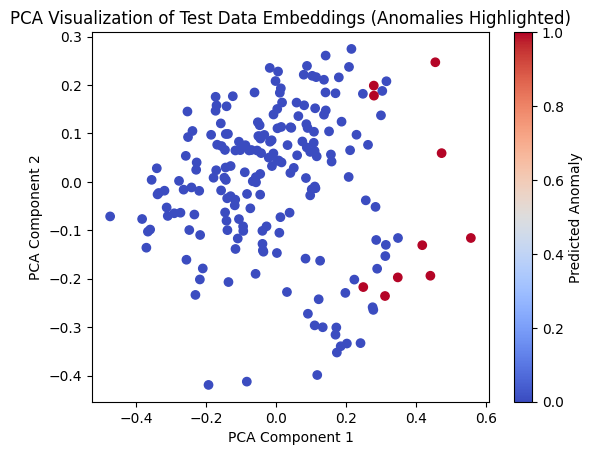

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import KNNImputer
from transformers import T5Tokenizer, T5EncoderModel
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 1. Generate Synthetic Data (with anomalies)
def generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1):
    np.random.seed(42)

    # Normal data (Gaussian distribution)
    normal_data = np.random.normal(loc=50, scale=10, size=(int(num_samples * (1 - anomaly_ratio)), 4))
    normal_labels = np.array([0] * len(normal_data))  # 0 indicates 'Normal'

    # Anomalies (Random uniform distribution)
    anomalies = np.random.uniform(low=10, high=90, size=(int(num_samples * anomaly_ratio), 4))
    anomaly_labels = np.array([1] * len(anomalies))  # 1 indicates 'Anomaly'

    # Combine normal data and anomalies
    data = np.vstack([normal_data, anomalies])
    labels = np.hstack([normal_labels, anomaly_labels])

    # Create DataFrame
    columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
    df = pd.DataFrame(data, columns=columns)
    df['label'] = labels
    return df

# 2. Introduce anomalies
synthetic_data = generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1)

# Split the data into train and test (80% train, 20% test)
train_data, test_data = train_test_split(synthetic_data, test_size=0.2, random_state=42)

# 3. Load T5 Model and Tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5EncoderModel.from_pretrained(model_name)

# Convert numeric features to a string format to use as input to T5
train_data['text'] = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)
test_data['text'] = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)

# 4. Function to Generate Embeddings from T5's Encoder
def get_t5_embeddings(text_data):
    inputs = tokenizer(text_data.tolist(), return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    # Mean pooling to get a single vector representation for each input
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

# Generate embeddings for train and test data
train_embeddings = get_t5_embeddings(train_data['text'])
test_embeddings = get_t5_embeddings(test_data['text'])

# 5. Use Cosine Similarity to Detect Anomalies
# Calculate cosine similarity between test embeddings and train embeddings
similarity_matrix = cosine_similarity(test_embeddings, train_embeddings)
average_similarity = similarity_matrix.mean(axis=1)

# Set a threshold to flag the bottom 5% as anomalies
threshold = np.percentile(average_similarity, 5)
test_data['predicted_anomaly'] = (average_similarity < threshold).astype(int)

# 6. Evaluate Performance
# Calculate precision, recall, and F1-score
precision = precision_score(test_data['label'], test_data['predicted_anomaly'])
recall = recall_score(test_data['label'], test_data['predicted_anomaly'])
f1 = f1_score(test_data['label'], test_data['predicted_anomaly'])

# Calculate AUC-ROC if possible
try:
    auc_roc = roc_auc_score(test_data['label'], average_similarity)
except ValueError:
    auc_roc = None  # AUC-ROC can't be computed if all labels are the same in a small test sample

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
if auc_roc is not None:
    print(f"AUC-ROC: {auc_roc:.4f}")

# 7. Correct/Impute Anomalous Values
# For simplicity, we'll correct values for numeric columns only

# First, create a combined dataset of normal + anomalies
corrected_data = test_data.drop(columns=['text', 'predicted_anomaly'])

# Apply KNN Imputer for anomaly correction
knn_imputer = KNNImputer(n_neighbors=5)
corrected_values = knn_imputer.fit_transform(corrected_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

# Reassign the corrected values back to the dataframe
corrected_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = corrected_values

# 8. Evaluation and Plotting

# Plot original vs corrected
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=test_data['feature_1'], y=test_data['feature_2'], hue=test_data['predicted_anomaly'], palette='coolwarm')
plt.title('Original Test Data (Anomalies Highlighted)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=corrected_data['feature_1'], y=corrected_data['feature_2'], palette='coolwarm')
plt.title('Corrected Data after Imputation')

plt.tight_layout()
plt.show()

# Optional PCA visualization of the embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(test_embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_data['predicted_anomaly'], cmap='coolwarm')
plt.title("PCA Visualization of Test Data Embeddings (Anomalies Highlighted)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Predicted Anomaly')
plt.show()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/5, Loss: 0.3558
Epoch 2/5, Loss: 0.3156
Epoch 3/5, Loss: 0.3147
Epoch 4/5, Loss: 0.3024
Epoch 5/5, Loss: 0.2980


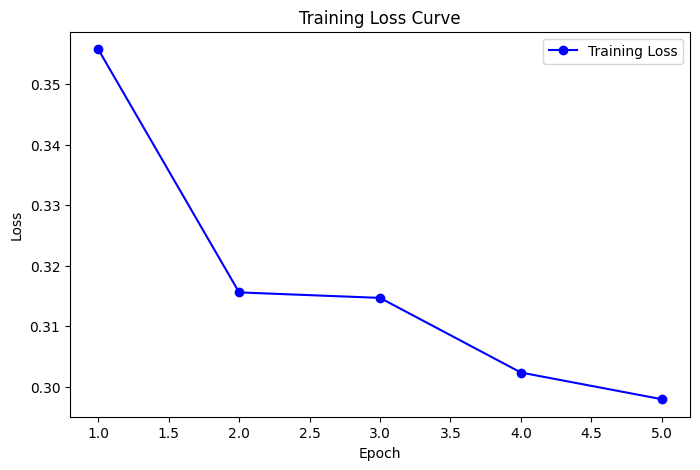

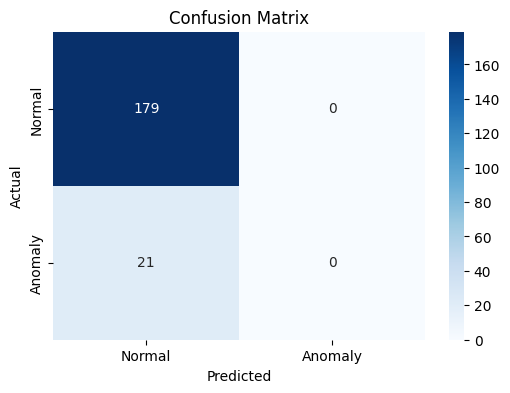


Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94       179
         1.0       0.00      0.00      0.00        21

    accuracy                           0.90       200
   macro avg       0.45      0.50      0.47       200
weighted avg       0.80      0.90      0.85       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


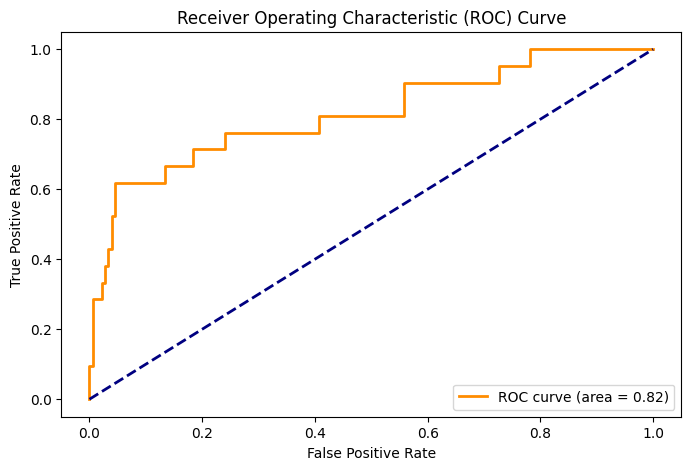

ROC-AUC Score: 0.82


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set up DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# 2. Generate Synthetic Data (anomalies included)
def generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1):
    np.random.seed(42)
    normal_data = np.random.normal(loc=50, scale=10, size=(int(num_samples * (1 - anomaly_ratio)), 4))
    normal_labels = np.zeros(len(normal_data))  # Label 0 for normal
    anomalies = np.random.uniform(low=10, high=90, size=(int(num_samples * anomaly_ratio), 4))
    anomaly_labels = np.ones(len(anomalies))  # Label 1 for anomalies

    data = np.vstack([normal_data, anomalies])
    labels = np.hstack([normal_labels, anomaly_labels])

    df = pd.DataFrame(data, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])
    df['label'] = labels
    return df

# Generate data
synthetic_data = generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1)
train_data, test_data = train_test_split(synthetic_data, test_size=0.2, random_state=42)

# Convert features to text format for DistilBERT
train_data['text'] = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)
test_data['text'] = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)

# 3. Function to Get Embeddings from DistilBERT
def get_embeddings(text_data):
    inputs = tokenizer(text_data.tolist(), return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Average over sequence dimension
    return embeddings

# Get embeddings for train and test datasets
train_embeddings = get_embeddings(train_data['text'])
test_embeddings = get_embeddings(test_data['text'])

# 4. Define Classification Head (Anomaly Detector)
class AnomalyDetector(nn.Module):
    def __init__(self, input_dim):
        super(AnomalyDetector, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Instantiate and prepare the anomaly detector model
input_dim = train_embeddings.shape[1]
anomaly_model = AnomalyDetector(input_dim)

# Convert labels to tensors and DataLoader preparation
train_labels = torch.tensor(train_data['label'].values).float().unsqueeze(1)
test_labels = torch.tensor(test_data['label'].values).float().unsqueeze(1)

train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 5. Train the Anomaly Detector Model
criterion = nn.BCELoss()
optimizer = optim.Adam(anomaly_model.parameters(), lr=0.001)
num_epochs = 5
train_losses = []

# Training loop
anomaly_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_embeddings, batch_labels in train_loader:
        optimizer.zero_grad()
        predictions = anomaly_model(batch_embeddings)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# 6. Evaluate on Test Data
anomaly_model.eval()
with torch.no_grad():
    test_predictions_proba = anomaly_model(test_embeddings).squeeze().numpy()
    test_predictions = (test_predictions_proba > 0.5).astype(int)

# 7. Print and Plot Evaluation Metrics

# Confusion Matrix
cm = confusion_matrix(test_data['label'], test_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_data['label'], test_predictions))

# ROC-AUC Score and ROC Curve
roc_auc = roc_auc_score(test_data['label'], test_predictions_proba)
fpr, tpr, thresholds = roc_curve(test_data['label'], test_predictions_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC Score: {roc_auc:.2f}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Confusion Matrix:
[[156  23]
 [ 18   3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       179
           1       0.12      0.14      0.13        21

    accuracy                           0.80       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.81      0.80      0.80       200

ROC-AUC Score: 0.51


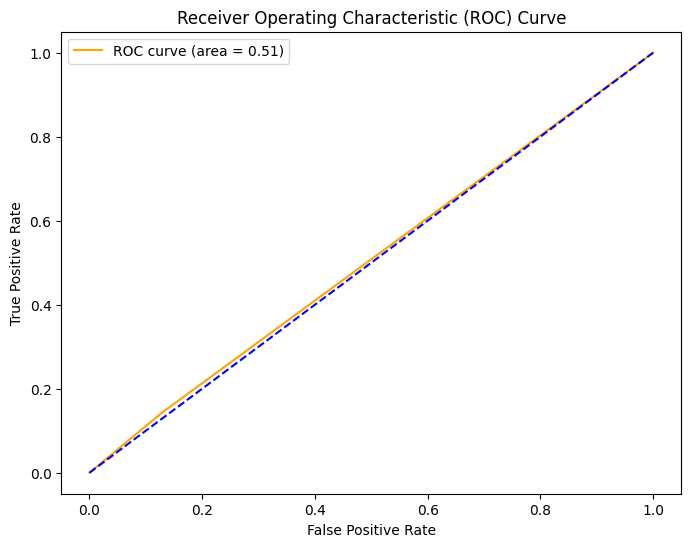

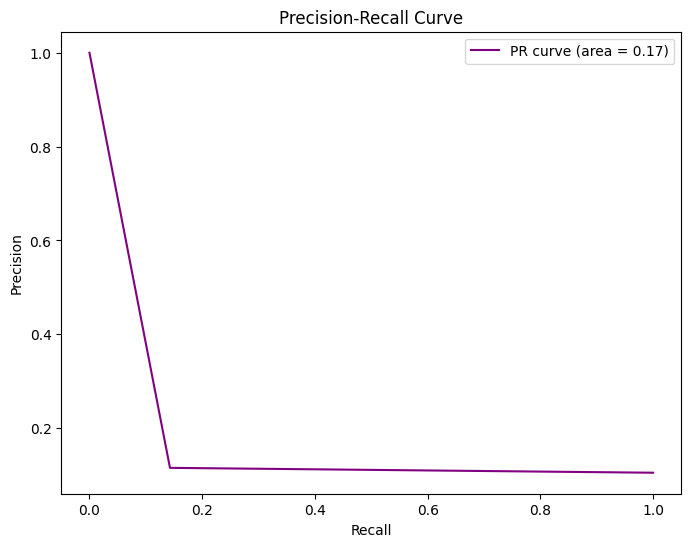

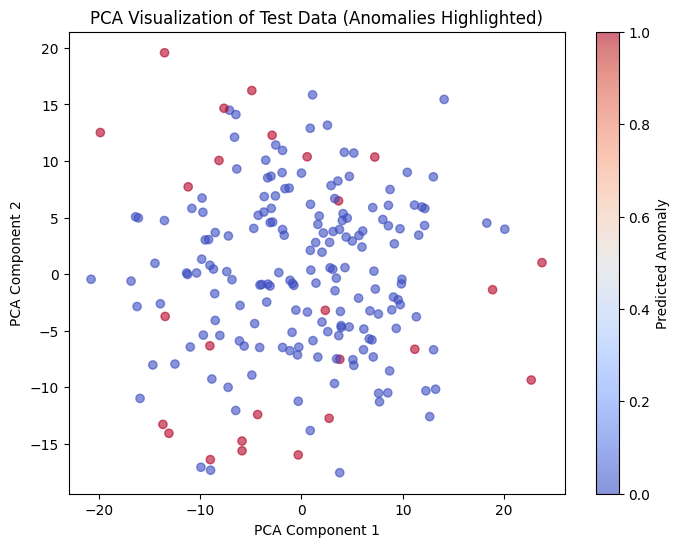

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# 1. Generate Synthetic Data
def generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1):
    np.random.seed(42)
    normal_data = np.random.normal(loc=50, scale=10, size=(int(num_samples * (1 - anomaly_ratio)), 4))
    normal_labels = np.array([0] * len(normal_data))
    anomalies = np.random.uniform(low=10, high=90, size=(int(num_samples * anomaly_ratio), 4))
    anomaly_labels = np.array([1] * len(anomalies))
    data = np.vstack([normal_data, anomalies])
    labels = np.hstack([normal_labels, anomaly_labels])
    columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
    df = pd.DataFrame(data, columns=columns)
    df['label'] = labels
    return df

synthetic_data = generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1)
train_data, test_data = train_test_split(synthetic_data, test_size=0.2, random_state=42)

# 2. Use DistilBERT to Generate Embeddings (with batching to save memory)
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

train_data['text'] = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)
test_data['text'] = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)

def get_embeddings_in_batches(text_data, batch_size=32):
    all_embeddings = []
    for i in range(0, len(text_data), batch_size):
        batch_texts = text_data[i:i+batch_size].tolist()
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True).to(model.device)
        with torch.no_grad():  # disable gradient calculation to save memory
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.append(batch_embeddings)
        torch.cuda.empty_cache()  # clear cache after each batch
    return np.vstack(all_embeddings)

# Get embeddings for train and test datasets
train_embeddings = get_embeddings_in_batches(train_data['text'])
test_embeddings = get_embeddings_in_batches(test_data['text'])

# 3. Combine the Embeddings with Numerical Features
# Combining the semantic embeddings with numerical features for better anomaly detection
train_numerical_features = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].values
test_numerical_features = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].values

# Combine text embeddings and numerical features
X_train_combined = np.hstack([train_embeddings, train_numerical_features])
X_test_combined = np.hstack([test_embeddings, test_numerical_features])

# 4. Standardize the Combined Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

# 5. Use Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y_pred_train = iso_forest.fit_predict(X_train_scaled)  # Fit on training data
y_pred_test = iso_forest.predict(X_test_scaled)  # Predict on test data

# Convert predictions to binary (1 = anomaly, 0 = normal)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

# 6. Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(test_data['label'], y_pred_test))
print("\nClassification Report:")
print(classification_report(test_data['label'], y_pred_test))

# ROC-AUC Score
roc_auc = roc_auc_score(test_data['label'], y_pred_test)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_data['label'], y_pred_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_data['label'], y_pred_test)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 7. Visualization with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(X_test_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_pred_test, cmap='coolwarm', alpha=0.6)
plt.title("PCA Visualization of Test Data (Anomalies Highlighted)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Predicted Anomaly')
plt.show()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Confusion Matrix:
[[157  22]
 [ 16   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       179
           1       0.19      0.24      0.21        21

    accuracy                           0.81       200
   macro avg       0.55      0.56      0.55       200
weighted avg       0.83      0.81      0.82       200

ROC-AUC Score: 0.56


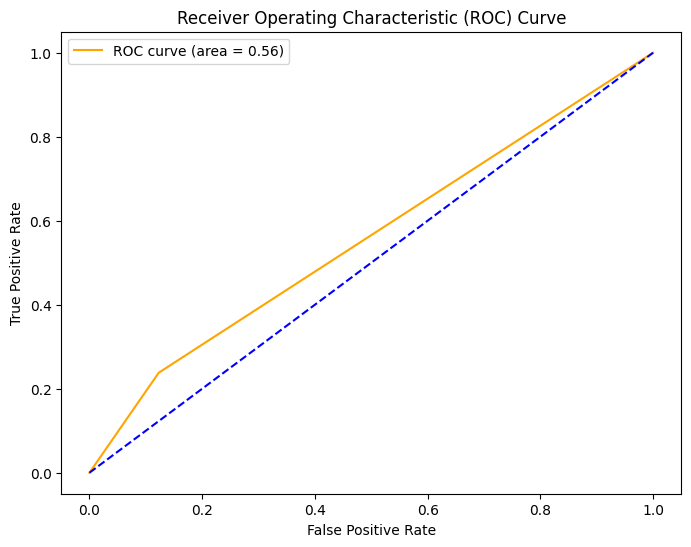

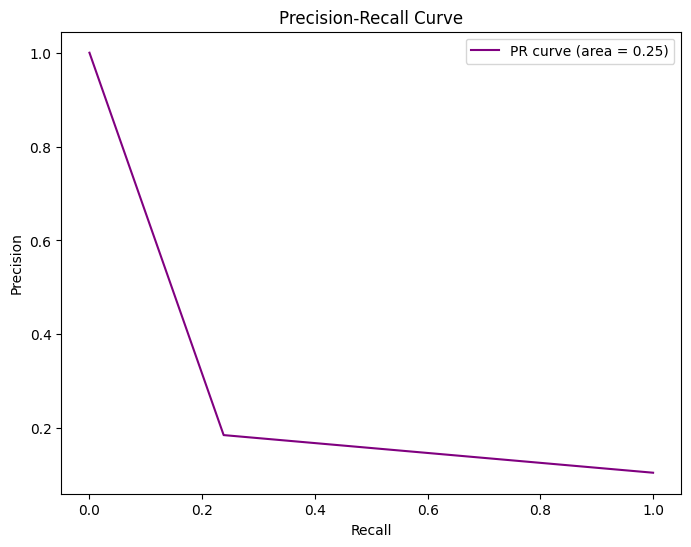

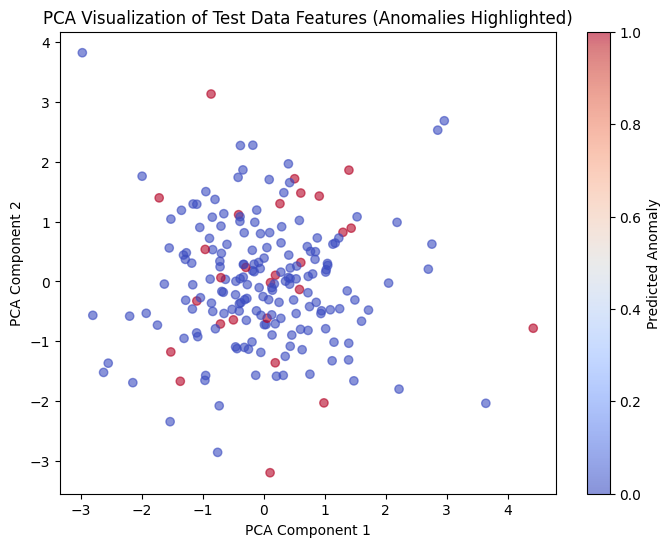

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import StandardScaler

# 1. Generate Synthetic Data (you can replace this with your dataset)
def generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1):
    np.random.seed(42)
    normal_data = np.random.normal(loc=50, scale=10, size=(int(num_samples * (1 - anomaly_ratio)), 4))
    normal_labels = np.array([0] * len(normal_data))
    anomalies = np.random.uniform(low=10, high=90, size=(int(num_samples * anomaly_ratio), 4))
    anomaly_labels = np.array([1] * len(anomalies))
    data = np.vstack([normal_data, anomalies])
    labels = np.hstack([normal_labels, anomaly_labels])
    columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
    df = pd.DataFrame(data, columns=columns)
    df['label'] = labels
    return df

synthetic_data = generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1)
train_data, test_data = train_test_split(synthetic_data, test_size=0.2, random_state=42)

# 2. Initialize BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# 3. Convert numerical data into textual format for BERT
train_data['text'] = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)
test_data['text'] = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']].astype(str).agg(' '.join, axis=1)

# 4. Function to get BERT embeddings
def get_embeddings_in_batches(text_data, batch_size=32):
    all_embeddings = []
    for i in range(0, len(text_data), batch_size):
        batch_texts = text_data[i:i+batch_size].tolist()
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True).to(model.device)
        with torch.no_grad():  # Disable gradient calculation to save memory
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Mean of token embeddings
            all_embeddings.append(batch_embeddings)
        torch.cuda.empty_cache()  # Clear GPU cache after each batch
    return np.vstack(all_embeddings)

# 5. Get BERT embeddings for train and test data
train_embeddings = get_embeddings_in_batches(train_data['text'])
test_embeddings = get_embeddings_in_batches(test_data['text'])

# 6. Standardize numerical features
scaler = StandardScaler()
train_numerical = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
test_numerical = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']]

train_numerical_scaled = scaler.fit_transform(train_numerical)
test_numerical_scaled = scaler.transform(test_numerical)

# 7. Combine numerical features with BERT embeddings
train_features = np.concatenate([train_embeddings, train_numerical_scaled], axis=1)
test_features = np.concatenate([test_embeddings, test_numerical_scaled], axis=1)

# 8. Apply Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # Adjust contamination based on your data
iso_forest.fit(train_features)

# Predict anomalies
train_data['predicted_anomaly'] = iso_forest.predict(train_features)
test_data['predicted_anomaly'] = iso_forest.predict(test_features)

# Convert -1 (anomalies) and 1 (normal) to binary labels
train_data['predicted_anomaly'] = (train_data['predicted_anomaly'] == -1).astype(int)
test_data['predicted_anomaly'] = (test_data['predicted_anomaly'] == -1).astype(int)

# 9. Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(test_data['label'], test_data['predicted_anomaly']))
print("\nClassification Report:")
print(classification_report(test_data['label'], test_data['predicted_anomaly']))

# ROC-AUC Score
roc_auc = roc_auc_score(test_data['label'], test_data['predicted_anomaly'])
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_data['label'], test_data['predicted_anomaly'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_data['label'], test_data['predicted_anomaly'])
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 10. Visualize Predicted Anomalies using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(test_features)
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=test_data['predicted_anomaly'], cmap='coolwarm', alpha=0.6)
plt.title("PCA Visualization of Test Data Features (Anomalies Highlighted)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Predicted Anomaly')
plt.show()


In [ ]:
!pip install faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Confusion Matrix:
[[ 38 141]
 [  0  21]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.21      0.35       179
           1       0.13      1.00      0.23        21

    accuracy                           0.29       200
   macro avg       0.56      0.61      0.29       200
weighted avg       0.91      0.29      0.34       200

ROC-AUC Score: 0.61


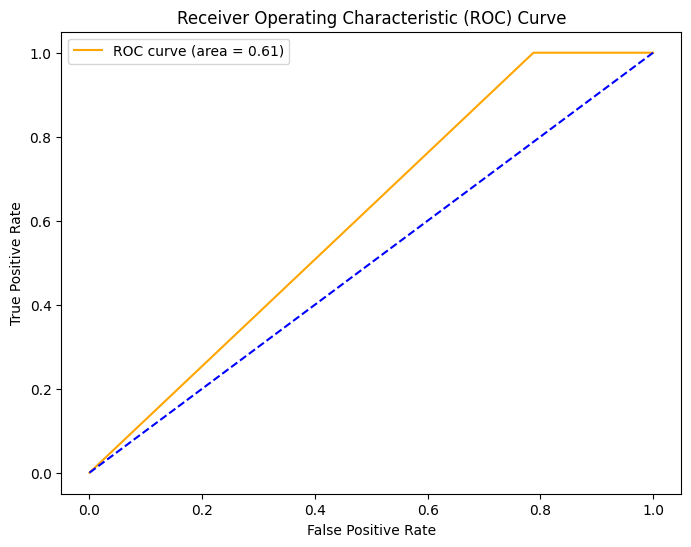

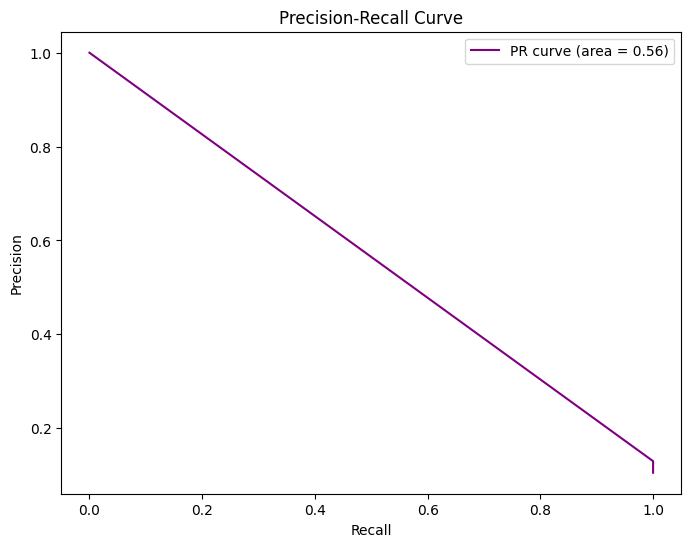

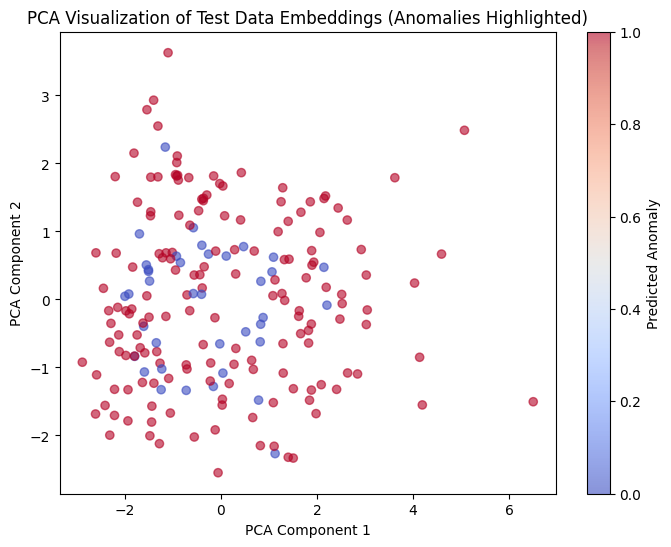

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from faker import Faker

# 1. Generate Synthetic Data with Text and Numeric Features
def generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1):
    np.random.seed(42)
    fake = Faker()

    # Numeric features
    normal_data = np.random.normal(loc=50, scale=10, size=(int(num_samples * (1 - anomaly_ratio)), 4))
    normal_labels = np.array([0] * len(normal_data))

    # Anomalies
    anomalies = np.random.uniform(low=10, high=90, size=(int(num_samples * anomaly_ratio), 4))
    anomaly_labels = np.array([1] * len(anomalies))

    # Combine normal and anomaly data
    data = np.vstack([normal_data, anomalies])
    labels = np.hstack([normal_labels, anomaly_labels])

    # Generating random product descriptions using Faker
    descriptions = [fake.sentence() for _ in range(len(data))]

    # Create DataFrame
    columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
    df = pd.DataFrame(data, columns=columns)
    df['text'] = descriptions
    df['label'] = labels
    return df

synthetic_data = generate_synthetic_data(num_samples=1000, anomaly_ratio=0.1)
train_data, test_data = train_test_split(synthetic_data, test_size=0.2, random_state=42)

# 2. Use BERT to Generate Textual Embeddings
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

train_data['text'] = train_data['text'].astype(str)
test_data['text'] = test_data['text'].astype(str)

def get_embeddings_in_batches(text_data, batch_size=32):
    all_embeddings = []
    for i in range(0, len(text_data), batch_size):
        batch_texts = text_data[i:i+batch_size].tolist()
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True).to(model.device)
        with torch.no_grad():  # disable gradient calculation to save memory
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.append(batch_embeddings)
        torch.cuda.empty_cache()  # clear cache after each batch
    return np.vstack(all_embeddings)

# Get embeddings for train and test datasets
train_embeddings = get_embeddings_in_batches(train_data['text'])
test_embeddings = get_embeddings_in_batches(test_data['text'])

# 3. Standardize Numerical Features
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test_data_scaled = scaler.transform(test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

# 4. Combine Numerical Features and Textual Embeddings
train_features_combined = np.hstack([train_data_scaled, train_embeddings])
test_features_combined = np.hstack([test_data_scaled, test_embeddings])

# 5. One-Class SVM for Anomaly Detection
model_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
model_svm.fit(train_features_combined)

# Predict anomalies in test data
y_pred = model_svm.predict(test_features_combined)
y_pred = (y_pred == -1).astype(int)  # Convert to binary (1 for anomaly, 0 for normal)

# 6. Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(test_data['label'], y_pred))
print("\nClassification Report:")
print(classification_report(test_data['label'], y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(test_data['label'], y_pred)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_data['label'], y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_data['label'], y_pred)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 7. PCA for Visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(test_features_combined)
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title("PCA Visualization of Test Data Embeddings (Anomalies Highlighted)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Predicted Anomaly')
plt.show()


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

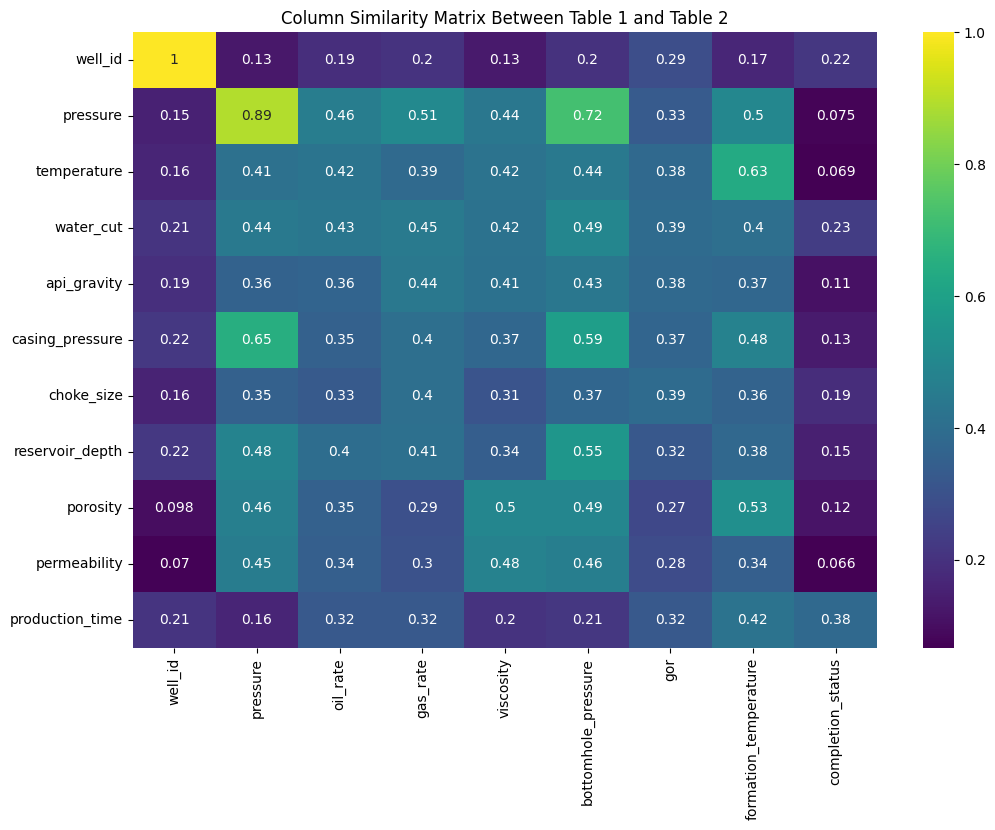

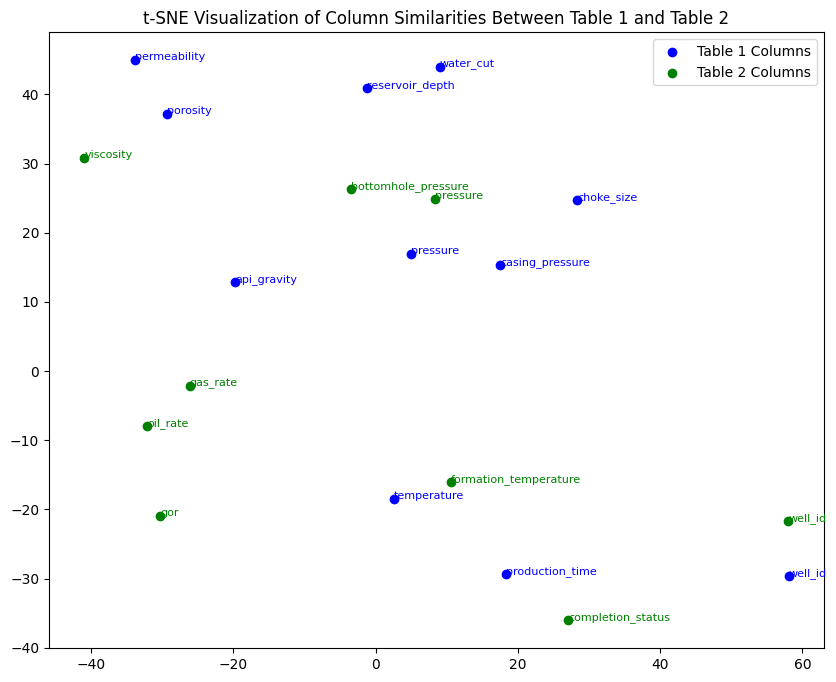

Final Integrated Dataset Columns: ['well_id', 'pressure', 'temperature', 'water_cut', 'api_gravity', 'casing_pressure', 'choke_size', 'reservoir_depth', 'porosity', 'permeability', 'production_time', 'well_id_from_table2', 'pressure_from_table2', 'oil_rate', 'gas_rate', 'viscosity', 'bottomhole_pressure', 'gor', 'formation_temperature', 'completion_status']


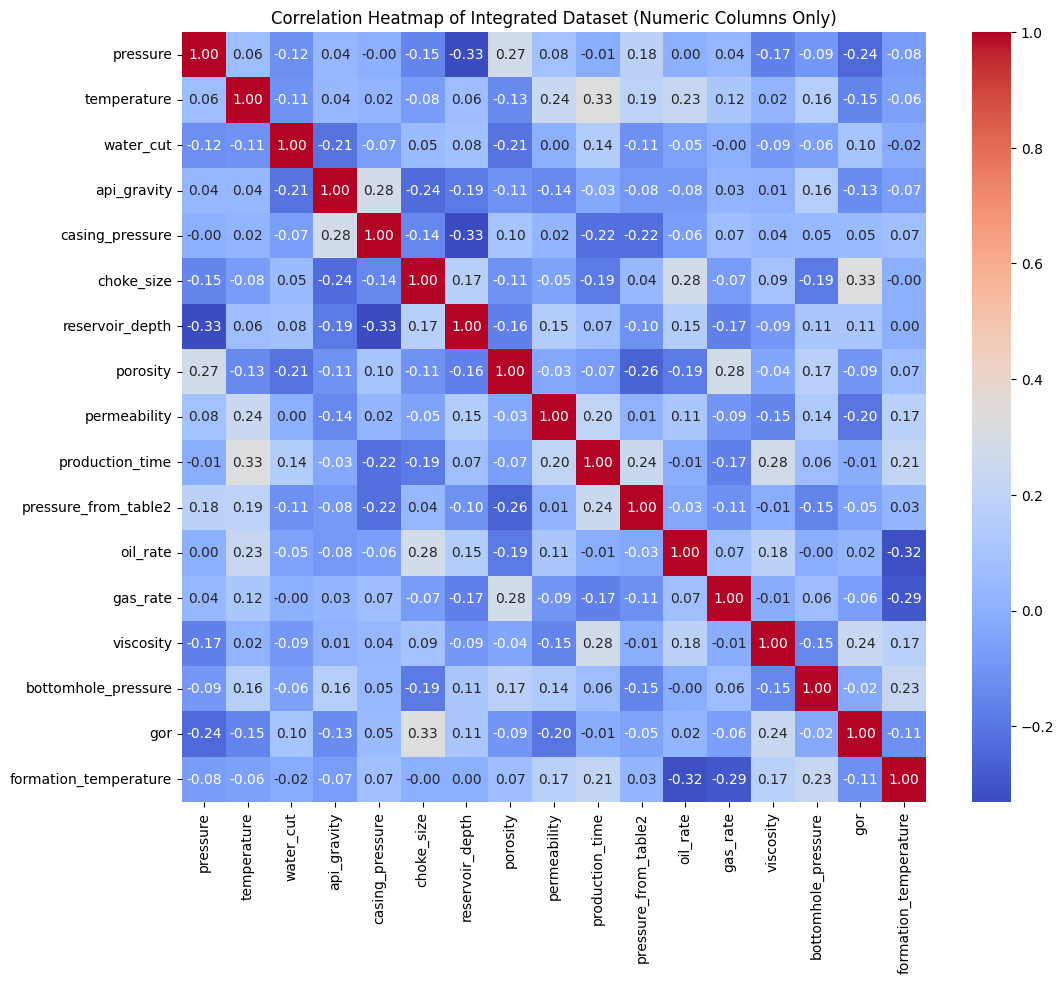

In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the data
np.random.seed(42)
num_wells = 50
well_ids = [f"Well{i+1}" for i in range(num_wells)]

# Generate synthetic data for Table 1 (Source 1)
table1 = pd.DataFrame({
    "well_id": well_ids,
    "pressure": np.random.uniform(80, 150, num_wells),
    "temperature": np.random.uniform(150, 250, num_wells),
    "water_cut": np.random.uniform(0.2, 0.6, num_wells),
    "api_gravity": np.random.uniform(30, 45, num_wells),
    "casing_pressure": np.random.uniform(70, 140, num_wells),
    "choke_size": np.random.uniform(15, 30, num_wells),
    "reservoir_depth": np.random.uniform(2500, 5000, num_wells),
    "porosity": np.random.uniform(0.1, 0.25, num_wells),
    "permeability": np.random.uniform(100, 500, num_wells),
    "production_time": np.random.randint(6, 120, num_wells)
})

# Generate synthetic data for Table 2 (Source 2) with different ranges
table2 = pd.DataFrame({
    "well_id": well_ids,
    "pressure": np.random.uniform(85, 155, num_wells),  # Slightly different range
    "oil_rate": np.random.uniform(30, 110, num_wells),  # Increased range to simulate higher oil rates
    "gas_rate": np.random.uniform(850, 1600, num_wells),  # Adjusted to reflect gas rate differences
    "viscosity": np.random.uniform(20, 40, num_wells),  # Broader range for viscosity
    "bottomhole_pressure": np.random.uniform(65, 135, num_wells),  # Slightly adjusted range
    "gor": np.random.uniform(120, 320, num_wells),  # Slightly higher GOR range
    "formation_temperature": np.random.uniform(140, 260, num_wells),  # Different range for formation temperature
    "completion_status": np.random.choice(["Producing", "Shut-in", "Abandoned"], num_wells)
})


# Load model and tokenizer to embed column names and data
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to generate embeddings from column name and sample data
def get_column_data_embeddings(column_name, column_data):
    # Convert the first value of the column to string and concatenate with column name
    sample_value = column_data.iloc[0]  # First value of the column
    combined_text = f"{column_name}: {sample_value}"  # Combine column name and data sample

    # Tokenize and generate embeddings
    inputs = tokenizer(combined_text, return_tensors="pt")
    with torch.no_grad():
        outputs = embedder(**inputs)

    # Mean-pool over the token dimension (dim=1) to get a single embedding
    embedding = outputs.last_hidden_state.mean(dim=1)
    return embedding.cpu().numpy().flatten()  # Flatten to ensure 2D shape for each column

# Generate embeddings for all columns in both tables using column names + sample data
table1_columns = list(table1.columns)
table2_columns = list(table2.columns)

# Create embeddings for each column in both tables
table1_embeddings = [get_column_data_embeddings(col, table1[col]) for col in table1_columns]
table2_embeddings = [get_column_data_embeddings(col, table2[col]) for col in table2_columns]

# Stack embeddings for Table 1 and Table 2 separately
table1_embeddings = np.vstack(table1_embeddings)
table2_embeddings = np.vstack(table2_embeddings)

# Calculate cosine similarity between Table 1 and Table 2 embeddings
similarity_matrix = cosine_similarity(table1_embeddings, table2_embeddings)

# Update column names for proper labeling
row_labels = table1_columns  # Columns from Table 1
col_labels = table2_columns  # Columns from Table 2


# Plot similarity matrix without redundant columns
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, annot=True, xticklabels=col_labels, yticklabels=row_labels, cmap="viridis")
plt.title("Column Similarity Matrix Between Table 1 and Table 2")
plt.show()

# t-SNE Visualization
from sklearn.manifold import TSNE
# Combine embeddings for t-SNE but keep track of table boundaries
combined_embeddings = np.vstack([table1_embeddings, table2_embeddings])

# Perform t-SNE on the combined embeddings
tsne = TSNE(n_components=2, metric="cosine", random_state=42, perplexity=5)
tsne_results = tsne.fit_transform(combined_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))

# Plot Table 1 columns
plt.scatter(tsne_results[:len(table1_columns), 0], tsne_results[:len(table1_columns), 1],
            color="blue", label="Table 1 Columns")

# Plot Table 2 columns
plt.scatter(tsne_results[len(table1_columns):, 0], tsne_results[len(table1_columns):, 1],
            color="green", label="Table 2 Columns")

# Annotate column names for better interpretation
for i, col in enumerate(table1_columns):
    plt.annotate(col, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8, color="blue")
for i, col in enumerate(table2_columns):
    plt.annotate(col, (tsne_results[len(table1_columns) + i, 0], tsne_results[len(table1_columns) + i, 1]),
                 fontsize=8, color="green")

# Add titles and legend
plt.title("t-SNE Visualization of Column Similarities Between Table 1 and Table 2")
plt.legend()
plt.show()

# Integrate datasets without unnecessary suffixes
integrated_data = table1.copy()

# Add columns from Table 2 that don't already exist in Table 1
for col in table2.columns:
    if col in table1.columns:
        # If column exists in both tables, rename the column from Table 2 with '_from_table2'
        integrated_data[f"{col}_from_table2"] = table2[col]
    else:
        # If the column is unique to Table 2, add it as is
        integrated_data[col] = table2[col]

# Final integrated dataset with relevant columns from both tables
print(f"Final Integrated Dataset Columns: {list(integrated_data.columns)}")

# Generate correlation heatmap
numeric_data = integrated_data.select_dtypes(include=[np.number])

# Plot a heatmap to visualize correlations between numeric columns
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Integrated Dataset (Numeric Columns Only)")
plt.show()
